# **World Series Predictions**

- Justin Radist
- Suneet Pathangay
- Zhenzhen Liu
- Elijah Sandler

## Abstract

We came to the following results after analyzing our data. For each batting stat, a maximum of three of the last ten World Series winners led the league in that stat during their championship year(Number of World Series Winners Over the Past 25 Seasons that led the MLB in the Various Batting Stats). Additionally, nearly all of the World Series winners in the last 10 seasons have displayed above-average performance in the five specified batting statistics(H, HR, RBi, Ba, and Ops). The results from these statistics show how the regular season is not a good predictor of playoff performance due to there being a ton of randomness amongst different teams statisitcs. We found out that different teams led in different statisitics in both batting and other fields leading to a large level of randomness.



Link for graph showing the win probability distribution for all the major sports versus baseball

![Alt Text](https://cdn.shortpixel.ai/spai/w_1200+q_lossy+ret_img+to_webp/https://www.elderresearch.com/wp-content/uploads/2022/11/best-team_figure1.png)


Link for graph showing how often the best teams win their respective titles

![Alt Text](https://cdn.shortpixel.ai/spai/w_936+q_lossy+ret_img+to_webp/https://www.elderresearch.com/wp-content/uploads/2022/11/fig3.png)

## Introduction
When the Major League Baseball playoffs come around every October, predictions and bets about which team will win the World Series intensify. While there are always differing opinions, the unbiased consensus regarding the favorite is almost always the team with the highest regular season win total. However, this prediction is usually wrong - the winningest regular season team has only won the World Series 4 times in the last 30 seasons (excludes the 1994 season that had no World Series due to a players strike). Further, a 2022 [Elder Research study](https://www.elderresearch.com/blog/how-often-does-the-best-team-win-the-title/#:~:text=The%20MLB's%20best%20team%2C%20on,the%20best%20regular%20season%20team) found that teams' perceived skill levels ("power ratings") correctly predicted ~56% of regular season winners in simulations but only ~31% of World Series winners. This 25% discrepancy is the largest of the 4 major professional sports organizations in America (MLB, National Football League, National Basketball Association, National Hockey League), and means having such a long regular season (162 games) does not necessarily translate to more predictable World Series winners.

This raises some questions regarding World Series predictions:
- Why is regular season wins such a poor predictor of World Series champion? Is it primarily due to level of randomness in team performances in each individual game, the format of the playoffs, or other factors?
- Do any overall team statistics, have a material impact on playoff performance and World Series winners?
- Can we determine metrics that are greater predictors of World Series winners than regular season wins? Can we build a model that predicts these metrics for future seasons and uses these projections to predict future World Series winners?

## Data Description
All of the data for this project was scraped from [baseball-reference.com](baseball-reference.com), which is the baseball branch of Sports Reference LLC. The data is pulled from multiple pages on the site, a page of World Series winners, and pages of  stats for each team by year. 

#### Webscraping and Data Cleaning

In [130]:
# import statements
import requests
from bs4 import BeautifulSoup
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
#import re
from bs4 import Comment
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn import tree
from copy import copy
import random

#### Cleaning Data and Building Dataframes
Because baseball-reference limits calls to its site, we created the below functions to first check if we have already scraped the data, then, if we haven't, to store the call so we never have to make it again. These function collect one year of pitching or batting data for one team, broken down by player. This will be very useful if we decide to extend this project's use in the future. 

In [131]:
dict_team_batting = defaultdict(lambda: dict())
def get_batting_df(team_code, dict_team_batting=dict_team_batting, year=2023):
    """ Gets the batting table for a given team. if table is not stored, adds it to dictionary 
    
    Args:
        team_code (str): short team abbreviation used by Baseball Reference
        dict_team_batting (dict): dictionary containing all queries we've made before
        year(int): the year we want data from, defaults to 2023

    Returns:
        dict_team_batting[year][team_code] (pd.DataFrame): dataframe of batting stats for given team and year
    """
    
    if team_code in dict_team_batting.keys():
        return dict_team_batting[year][team_code]
    
    else:
        url = f"https://www.baseball-reference.com/teams/{team_code}/{str(year)}.shtml"
        df_batting = pd.read_html(url)[0]
        time.sleep(4)
        
        df_filtered = pd.DataFrame()
        for idx in df_batting.index:
            try:
                int(df_batting.loc[idx, 'Rk'])
                df_filtered = pd.concat([df_filtered, df_batting.loc[idx, :]], axis=1)
            except(ValueError):
                pass
        
        dict_team_batting[year][team_code] = df_filtered.T
        
    return dict_team_batting[year][team_code]

In [132]:
dict_team_pitching = defaultdict(lambda: dict())
def get_pitching_df(team_code, dict_team_pitching=dict_team_pitching, year=2023):
    """ Gets the pitching table for a given team. if table is not stored, adds it to dictionary 
    
    Args:
        team_code (str): short team abbreviation used by baseball reference
        dict_team_pitching (dict): dictionary containing all queries we've made before
        year(int): year we want data from, defaults to 2023
    Returns:
        dict_team_pitching[year][team_code] (pd.DataFrame): dataframe of pitching stats for given team and year
    """
    
    if team_code in dict_team_pitching[year].keys():
        return dict_team_pitching[year][team_code]
    
    else:
        url = f"https://www.baseball-reference.com/teams/{team_code}/{str(year)}.shtml"
        df_pitching = pd.read_html(url)[1]
        time.sleep(4)
        
        df_filtered = pd.DataFrame()
        for idx in df_pitching.index:
            try:
                int(df_pitching.loc[idx, 'Rk'])
                df_filtered = pd.concat([df_filtered, df_pitching.loc[idx, :]], axis=1)
            except(ValueError):
                pass
          
        dict_team_pitching[year][team_code] = df_filtered.T
        
    return dict_team_pitching[year][team_code]

This variation gets batting statistics

In [5]:
# currently only used for a data analysis plan graph
def get_season_batting_df(season):
    """ Gets a table of common batting stats organized by MLB team for a given season
    Args:
        season (int): the season to get data for
    
    Returns:
         df_season_batting (pd.DataFrame): a dataframe of batting stats by team for a season
    """
    url = f'https://www.baseball-reference.com/leagues/majors/{season}.shtml'
    
    df_season_batting = pd.read_html(url)[0]
    time.sleep(4)
    
    return df_season_batting

In [133]:
team_abbrevs_dict = {'Arizona Diamondbacks': 'ARI', 'Atlanta Braves': 'ATL', 'Baltimore Orioles': 'BAL',
                     'Boston Red Sox': 'BOS', 'Chicago Cubs': 'CHC', 'Chicago White Sox': 'CWS',
                     'Cincinnati Reds': 'CIN', 'Cleveland Guardians': 'CLE', 'Colorado Rockies': 'COL',
                     'Detroit Tigers': 'DET', 'Houston Astros': 'HOU', 'Kansas City Royals': 'KAN',
                     'Los Angeles Angels': 'LAA', 'Los Angeles Dodgers': 'LAD', 'Miami Marlins': 'MIA',
                     'Milwaukee Brewers': 'MIL', 'Minnesota Twins': 'MIN', 'New York Mets': 'NYM',
                     'New York Yankees': 'NYY', 'Oakland Athletics': 'OAK', 'Philadelphia Phillies': 'PHI',
                     'Pittsburgh Pirates': 'PIT', 'San Diego Padres': 'SDP', 'San Francisco Giants': 'SFG',
                     'Seattle Mariners': 'SEA', 'St. Louis Cardinals': 'STL', 'Tampa Bay Rays': 'TBR',
                     'Texas Rangers': 'TEX', 'Toronto Blue Jays': 'TOR', 'Washington Nationals': 'WAS'}

Now, we collect the historical World Series winners, and make sure to label the American League and National League winners. 

In [134]:
# get the World Series information
table = pd.read_html("https://www.baseball-reference.com/postseason/world-series.shtml")
time.sleep(4)
ws_data = table[0]

# rename win and win1 to AL Wins and NL Wins, respectively
ws_data.rename(columns={ws_data.columns[2]: 'AL Wins'}, inplace=True)
ws_data.rename(columns={ws_data.columns[3]: 'NL Wins'}, inplace=True)

In [136]:
# build dictionary of WS champions
ws_winner_dict = {}

for idx, row in ws_data.iterrows():
    if row['AL Wins'] == '4':
        ws_winner_dict[int(row['Year'])] = row['AL Winner']
    if row['NL Wins'] == '4':
        ws_winner_dict[int(row['Year'])] = row['NL Winner']

`seasonal_data` is the function that was used most for data collection. It creates two dataframes, one batting and one pitching, where each row represents a team's cumulative stats for the season. It allows us to collect data for all 30 teams simultaneously, but at the cost of not being able to break down the statistics by player. 

In [137]:
def seasonal_data(year):
    """ gets team batting and pitching data for a given season
    
    Args: 
        year (int): year of statistics
        
    Returns: 
        batting (df): dataframe of batting statistics
        pitching (df): dataframe of pitching statistics
    """
    url = f'https://www.baseball-reference.com/leagues/majors/{str(year)}.shtml'
    batting = pd.read_html(url)[0]
    # convert all values in table to float (except for team names)
    batting = pd.concat([batting.iloc[:30, 0], batting.iloc[:30, 1:].astype(float)], axis=1)
    
    """ for whatever reason, the html for the pitching table is commented out.
        so, we have to go in with bs4, find the tables in the comments, and then read that html. """
    
    response = requests.get(url)
    html_content = response.content

    # use bs4 to parse the HTML, including comments
    soup = BeautifulSoup(html_content, 'html.parser')

    # find all HTML comments
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))

    # extract tables from comments
    tables = []
    for comment in comments:
        comment_soup = BeautifulSoup(str(comment), 'html.parser')
        comment_tables = comment_soup.find_all('table')
        tables.extend(comment_tables) # not append

    pitching = pd.read_html(str(tables[1]))[0]
    # convert all values in table to float (except for team names)
    pitching = pd.concat([pitching.iloc[:30, 0], pitching.iloc[:30, 1:].astype(float)], axis=1)
    
    # clean tables
    batting_filtered = pd.DataFrame()
    for idx in batting.index:
        try:
            int(batting.loc[idx, '#Bat'])
            batting_filtered = pd.concat([batting_filtered, batting.loc[idx, :]], axis=1)
        except(ValueError):
            pass
        
    pitching_filtered = pd.DataFrame()
    for idx in pitching.index:
        try:
            int(pitching.loc[idx, '#P'])
            pitching_filtered = pd.concat([pitching_filtered, pitching.loc[idx, :]], axis=1)
        except(ValueError):
            pass
    
    # don't get timed out
    time.sleep(8.2)
    return batting, pitching

In [139]:
b, p = seasonal_data(2023);

C:\Users\elija\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


The below code scrapes all MLB playoff history data, so that we can attempt to predict more than just World Series winners. 

In [140]:
# get data table of all MLB playoff history. then rename columns
playoff_data = pd.read_html('https://www.baseball-reference.com/postseason/')[0]
playoff_data.rename(columns={playoff_data.columns[1]: 'Series Outcome'}, inplace=True)
playoff_data.rename(columns={playoff_data.columns[2]: 'Matchup'}, inplace=True)

# get playoff success for all teams for the past 25 seasons and make into a df
num_seasons = 25
years = list(map(lambda x: 2023 - x, range(num_seasons)))
year_success = []
playoff_success_df = pd.DataFrame()

for year in years:
    temp_slice = playoff_data[playoff_data['Series'].str.contains(str(year), na=False)]
    year_success = []
    for team in team_abbrevs_dict.keys():
        # check if team won WS
        if ws_winner_dict[int(year)] == team:
            year_success.append(5)
        # if team didn't win WS, check if they made it to WS
        elif team in temp_slice.iloc[0,2]:
            year_success.append(4)
        # if team didn't make it to WS, check if they made it to Championship Series (CS)
        elif temp_slice.iloc[1:3, 2].str.count(team).sum() > 0:
            year_success.append(3)
        # if team didn't make it to CS, check if they made it to Division Series (DS)
        elif temp_slice.iloc[3:7, 2].str.count(team).sum() > 0:
            year_success.append(2)
        # if team didn't make it to DS, check if they made it to Wild Card (WC) round
        elif temp_slice.iloc[7:, 2].str.count(team).sum() > 0:
            year_success.append(1)
        # if team didn't make playoffs, append 0
        else:
            year_success.append(0)

    year_series = pd.Series(year_success)
    playoff_success_df = pd.concat([playoff_success_df, year_series.to_frame().T])

# make df rows the seasons, make columns the teams/abbrevs (cells all contain 0, 1, 2, 3, 4, or 5)
playoff_success_df.columns = list(team_abbrevs_dict.values())
playoff_success_df.index = years

Finally, all of our data sources are combined into `master_df`. 

In [10]:
# master stat table with batting, pitching, and playoff success data for every team each of last 25 seasons
num_seasons = 25
years = list(map(lambda x: 2023 - x, range(num_seasons)))
master_df = pd.DataFrame()

for year in years:
    # get batting and pitching tables by team for current season
    b, p = seasonal_data(year)
    # combine batting and pitching dfs for 1 season into 1 df
    current_year_df = pd.concat([b, p], axis=1, ignore_index=True)
    current_year_list = pd.Series(map(lambda x: year, range(len(b))), name='Season')
    # add column identifying what season the current data is from
    current_year_df = pd.concat([current_year_list.to_frame(), current_year_df], axis=1)
    # add column of teams' playoff success
    playoff_col = playoff_success_df.loc[year].reset_index(drop=True)
    playoff_col = pd.Series(playoff_col, name='Playoff Round')
    current_year_df = pd.concat([current_year_df, playoff_col.to_frame()], axis=1)
    # add current year's df to master df
    master_df = pd.concat([master_df, current_year_df])

# save master_df to a CSV file. Do this to avoid timeout requests and for column renaming purposes
master_df.to_csv('master_df.csv', index=False)

/Users/justinradist/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


KeyboardInterrupt: 

In [141]:
# read back in CSV
master_df = pd.read_csv('master_df.csv')

In [15]:
# create list of columns names so batting and pitching columns with same names are distinguished (i.e., H)
cols = ['Season']
for col in b.columns:
    cols.append(col)
pitch_col_names = ['Tm_p', '#P', 'PAge', 'RA/G', 'W', 'L', 'W-L%', 'ERA', 'G_p', 'GS', 'GF', 'CG', 'tSho', 'cSho', 'SV', 'IP',
 'H_p', 'R_p', 'ER', 'HR_p', 'BB_p', 'IBB_p', 'SO_p', 'HBP_p', 'BK', 'WP', 'BF', 'ERA+', 'FIP', 'WHIP', 'H9',
 'HR9', 'BB9', 'SO9', 'SO/W', 'LOB_p']
for col in pitch_col_names:
    cols.append(col)
cols.append('Playoff Round')

# rename columns
master_df.rename(columns=dict(zip(master_df.columns, cols)), inplace=True)

In [143]:
master_df.head()

,Season,Tm,#Bat,BatAge,R/G,G,PA,AB,R,H,...,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W,LOB.1,Playoff Round
0,2023,Arizona Diamondbacks,54.0,27.4,4.60,162.0,6124.0,5436.0,746.0,1359.0,...,98.0,4.35,1.324,8.6,1.2,3.3,8.5,2.57,1050.0,4
1,2023,Atlanta Braves,53.0,27.9,5.85,162.0,6249.0,5597.0,947.0,1543.0,...,108.0,4.10,1.302,8.4,1.2,3.3,9.5,2.84,1112.0,2
2,2023,Baltimore Orioles,50.0,27.3,4.98,162.0,6123.0,5495.0,807.0,1399.0,...,106.0,3.98,1.243,8.3,1.1,2.9,8.9,3.03,1080.0,2
3,2023,Boston Red Sox,56.0,28.6,4.77,162.0,6174.0,5562.0,772.0,1437.0,...,101.0,4.37,1.338,8.9,1.3,3.1,9.0,2.86,1117.0,0
4,2023,Chicago Cubs,48.0,28.4,5.06,162.0,6220.0,5504.0,819.0,1399.0,...,110.0,4.16,1.283,8.3,1.1,3.2,8.6,2.68,1073.0,0


There is still cleaning to be done. Some statistics are repetitive or useless for our project, so they need to be removed. Also, statistics must be standardized across seasons. We did this by ranking each stat for each team from 1 to 30, where 1 represents the team with the best score for that stat in that season, and 30 is the worst. 

In [16]:
# remove uninformative stats from df 
#master_df.drop(['#Bat', 'G', 'PA', 'AB', 'TB', '#P', 'Tm.1', 'G.1', 'BF'], axis=1, inplace=True)
master_df.drop(['#Bat', 'G', 'PA', 'AB', 'TB', '#P', 'Tm_p', 'G_p', 'BF'], axis=1, inplace=True)

# remove informative but excess / repetitive stats from df
master_df.drop(['R/G', 'RA/G', 'W-L%', 'H9', 'HR9', 'BB9', 'SO9', 'SO/W'], axis=1, inplace=True)

In [17]:
# turn all values in master_df into ranks on a per season basis
low_is_better_stats = ['BatAge', 'CS', 'SO', 'GDP', 'LOB', 'PAge', 'RA/G', 'L', 'ERA', 'H.1', 'R.1', 'ER', 'HR.1',
                      'BB.1', 'IBB.1', 'HBP.1', 'BK', 'WP', 'WHIP', 'H9', 'HR9', 'BB9']
#low_is_better_stats = ['BatAge', 'CS', 'SO', 'GDP', 'LOB', 'PAge', 'RA/G', 'L', 'ERA', 'H_p', 'R_p', 'ER', 'HR_p',
                      #'BB_p', 'IBB_p', 'HBP_p', 'BK', 'WP', 'WHIP', 'H9', 'HR9', 'BB9']

#master_df_ranked = master_df_read[['Season', 'Tm']]
master_df_ranked = master_df[['Season', 'Tm']]
for col in list(master_df.columns)[2:-1]:
    col_rank = []
    for season in range(len(master_df['Season'].unique())):
        seasonal_df = master_df.iloc[season*30:season*30+30]
        if col in low_is_better_stats:
            temp_ranks = seasonal_df[col].rank(method='min')
        else:
            temp_ranks = seasonal_df[col].rank(ascending=False, method='min')
        for temp_rank in temp_ranks:
            col_rank.append(temp_rank)
    col_rank_series = pd.Series(col_rank, name=col).reset_index(drop=True)
    master_df_ranked = pd.concat([master_df_ranked, col_rank_series.to_frame()], axis=1)
master_df_ranked = pd.concat([master_df_ranked, master_df['Playoff Round'].to_frame()], axis=1)

In [18]:
# filter dfs for only rows of teams/seasons that made playoffs
master_df_playoffs = master_df[master_df['Playoff Round'] != 0]
master_df_ranked_playoffs = master_df_ranked[master_df_ranked['Playoff Round'] != 0]

## Preliminary Visualizations:
This visualization plots how many World Series winners led the league in each stat during the regular season of the year they won the World Series.

In [16]:
# CURRENTLY ONLY USED FOR ORIGINAL DATA ANALYSIS PLAN VISUALIZATION
def ws_winner_leading_data(team, year, num_teams=1):
    """ Get regular season stat leading data from a World Series winner
        
    Args:
        team (string): the name of the team
        year (int or string): the year that the team won the World Series
        num_teams (int): the lowest rank in the MLB a World Series winner can be in a stat to be considered a
        "leader" in that stat category (e.g., if num_teams is 3, then a World Series winner must have had one of
        the 3 highest stat values of any team in the MLB that season to be considered a "leader")
        
    Returns:
        None
    """
    # get table of aggregated batting data by team for a single season
    batting_table, _ = seasonal_data(year)
    time.sleep(4)
    batting_table.drop('G', axis=1, inplace=True)
    
    # loop through all stats in table
    for stat in list(batting_table.columns[3:]):
        # for each stat, convert its column of values to a list and sort in descending order
        stat_list = list(batting_table[stat])
        stat_list.sort(reverse=True)
        # find the cutoff stat value
        cutoff = stat_list[num_teams - 1]
        
        # if WS winner met/exceeded cutoff stat value, add 1 to the dict count of the current stat
        if (batting_table[batting_table[stat] >= cutoff]['Tm'] == team).any():
            if stat in stat_counts_dict.keys():
                stat_counts_dict[stat] += 1
            else:
                stat_counts_dict[stat] = 1
    return None

In [17]:
# CURRENTLY ONLY USED FOR ORIGINAL DATA ANALYSIS PLAN VISUALIZATION
# dictionary of counts of last 25 WS winners that were top 3 in the MLB in each batting stat
stat_counts_dict = {}
year_count = 0
for year, team in ws_winner_dict.items():
    if year_count > 25:
        break
    ws_winner_leading_data(team, year, num_teams=3)
    year_count += 1

stat_counts_dict

KeyboardInterrupt: 

In [ ]:
# CURRENTLY ONLY USED FOR ORIGINAL DATA ANALYSIS PLAN VISUALIZATION
# create bar chart of stats and how often World Series winners led the league in them
plt.bar(stat_counts_dict.keys(), stat_counts_dict.values())
plt.yticks(list(range(15)))

plt.xlabel('Team Batting Data')
plt.ylabel('Number World Series Winners that Led League')
plt.title('Number of World Series Winners Over the Past 25 Seasons that led the MLB in the Various Batting Stats')
plt.gcf().set_size_inches(13, 6)
plt.show()

As you can see in the graph above, for every batting stat, at most 3 of the last 10 World Series winners led the league in it the year they won. This is actually a greater percentage than the number of teams that led the MLB in regular season wins the year they won the World Series, which is somewhat promising for our project. One next step could be to expand from only counting World Series winners that led the entire MLB in a stat to counting World Series winners that were one of the top 3 or 5 teams in the MLB for a stat that season. This is likely to increase the counts substantially while still providing relevant info, since top 5 out of 30 teams in still in the highest quintile.

The visualization below displays scatter plots with 2 sets of data points on each plot: 1 color for the mean values by season, a different color for the set of values for World Series winners by season. We are looking to see if World Series winners consistently had well-above average values for any stat, which would indicate there might be some relationship between that stat and playoff success.

In [18]:
seasons = []
batting_stats = {'H': [],
                'HR': [],
                'RBI': [],
                'BA': [],
                'OPS': []}

# loop backwards through the past n seasons
for i in range(10):
    season = 2023 - i
    seasons.append(season)
    # pull df for current loop's season, set team name as the index
    df_season_batting = get_season_batting_df(season).set_index('Tm')
    time.sleep(4)
    # loop through all the stats in the dictionary initialized above
    for stat in list(batting_stats.keys()):
        # get the average team value for the current stat in the current season
        avg_stat_val = df_season_batting[stat][:30].astype(float).mean()
        
        # get the value for the current stat for the team that won the World Series in the current loop's season
        ws_winner = ws_winner_dict[season]
        ws_winner_stat_val = float(df_season_batting.loc[ws_winner][stat])
        
        # create 2-item list of mean stat value and World Series winner stat value for the current season
        temp_stat_list = [round(avg_stat_val, 3), round(ws_winner_stat_val, 3)]
        # add the 2-item list to list of the respective stat in the batting stats dictionary
        batting_stats[stat].append(temp_stat_list)

KeyboardInterrupt: 

In [ ]:
# plot mean team and WS winner values for each stat by season
sns.set_style('darkgrid')
for stat, values in batting_stats.items():
    temp_array = np.array(values)
    plt.scatter(seasons, temp_array[:, 0], label='Mean Value')
    plt.scatter(seasons, temp_array[:, 1], label='WS Winner Value')
    plt.xticks(seasons)
    plt.legend(bbox_to_anchor=(1.4, 1))
    plt.xlabel('Season')
    plt.ylabel(stat.capitalize())
    plt.title(f'Mean and WS Winner {stat.capitalize()} Values by Season')
    plt.show()

Almost all World Series winners have been above average in each of the above 5 batting statistics over the last 10 seasons. This supports our conclusions from the first visualization, which is that World Series winners perform well in these categories and that they may be better at predicting playoff success than regular season wins. Another next step will be to look at pitching stats in this same manner.

# JUSTIN YOU HAVE TO LOOK THROUGH THIS AND DECIDE WHAT TO KEEP

## Method
#### Random Forest Classifier
- At first, we decided to use linear regression model to analyze the baseball data, however, we realized that the playoff performance is hard to be predicted with simple regression model. Therefore, we decide to use Random Forest which is a qualitative model.
    - The reason we use Random Forest is that Random Forest can check the importance of each feature, which is very useful for our analysis. Each baseball statistic has different importance, for example, OBP may be considered more important than BA as an offensive statistic. Since some data are not that important for a team's playoff performance, we want to remove them when we are predicting the playoff winners. Less important data may misleading the outcome. By checking the data importance, we can choose the more important data to predict a team's playoff performance efficiently.
    - In addition, Random Forest can builds multiple decision trees during training. Each decision tree is constructed using a different subset of the data and features, therefore the outcome can be more precise.
    - We can easily visualize the feature importances in a horizontal bar chart, so that it's clearly which feature is more useful to predict the playoff performance, and then we can use the result to perdict the team performance in the next step.
- However, there is some pitfalls exist:
    - We are using the baseball data from the past 20 years, which is a long range. Within the years, teams and coaches may change their plan on how to win a game. Some statistics might be very important 10 years ago, but they may not be that important nowadays. Therefore, our prediction may be affected by the changing of the feature importance.

#### Decision Tree Classifier
- The reason we use Desicion Tree is because that the decision tree works good on predict data for each team individually.
- Moreover, the decision trees works good with feature importance from the result of our Random Forest method. This is valuable for our analysis, since in baseball, different statistics has different importance on the game. In order to predict the winner correctly, we have to correctly use the features.

Initially, we explored running regressions on our data to predict stats and playoff performance. However, playoff performance is a qualitative data point (i.e., "won World Series," "lost in NLCS," etc.), and while we quantified it (e.g., made playoffs = 1, won Wild Card round = 2, ..., won World Series = 5), it's still a discrete variable, so we decided to use classification models, specifically random forests and decision trees. We began by using a random forest to determine which batting and pitching statistics had the greatest impact on playoff performance. Then, we ran hundreds of decision trees to actually make these playoff predictions and determine model accuracies. The goal was to run decision trees for predictor variables individually, in small groups, and on all relevant statistics together. 

Assumptions and Pitfalls:
- Both decision trees and random forest classifiers assume all predictor features are independent, but many baseball stats are not. We tried to maximize level of independence between the variables by removing stats that were repetitive or based off of others, such as home runs per 9 innings (HR9) which is dependent on home runs (HR) and runs per game (R/G) which is dependent on runs (R). However, we could not guarantee complete independence entirely since many stats are important but not independent, such as hits (H) and home runs, or slugging percentage (SLG) and on base plus slugging (OPS). This contributes to less confidence in our models.
- Another potential pitfall of random forest classifiers, although we were able to avoid it, is absolute values of mean reductions in Gini are partly dependent on the number of variables passed into the model, so a model with fewer predictor variables may result in each variable appearing to have a larger impact on the variable being predicted. We avoided this by only running random forests on all relevant stats.
- We don't use any built-in cross validation function for our decision tree model. Rather, we slice the data to exclude the rows of data for the season we want to predict and use that as the test data. All the other seasons are the training data, effectively creating a test size of 0.04 for 25 seasons or 0.10 for 10 seasons. Of note: for any season that isn't the most recent MLB season (currently 2023), the playoff predictions are partly based off of data from future seasons, meaning not only historical data is used in our predictions. This is not necessarily a pitfall but rather something to keep in mind.
- 25 years is a long time span, and statistics considered important 25 years ago are not considered as important now and vice versa. For instance, OPS was a niche statistic in the 2000s, but now is a key stat in evaluating team and individual player output. Neither model accounts for changing feature importances with time or seasons, assuming these are constant, which could detract from model confidence.

## Machine Learning and Results

In [19]:
def rf_classifier(df, x_feat_list, y=None, max_depth=4, n_splits=6, cross_val=False):
    """ build a Random Forest Classifier model
    
    Args: 
        df (pd.DataFrame): dataframe to run
        x_feat_list (list): list of columns in df being used to predict the y feature
        y (str): column in df to predict
        max_depth (int): maximum depth each decision tree in the random forest should go
        cross_val (bool): if True, model should be cross validated
        n_splits (int): if model is meant to be cross validated, this
        is how many times to split the data when cross validating
    Returns:
        rf_class (RandomForestClassifier): a random forest classifier model
    """
    # default x_feat_list, features to predict stats upon
    if x_feat_list is None:
        x_feat_list = ['R/G', 'BA', 'OPS', 'ERA', 'WHIP', 'SO9']
    
    # default y, feature to estimate
    if y is None:
        y = 'Playoff Round'

    # get columns of predictor stats (x), and get column of feature being predicted (y)
    x = df[x_feat_list].values
    y_true = df[y].values

    # initialize a rf_classifier with a max depth of default 4
    rf_class = RandomForestClassifier(n_estimators=100, max_depth=max_depth)

    # run non-cross validated model
    if cross_val == False:
        rf_class.fit(x, y_true)
        # predict y (from classifier)
        y_pred = rf_class.predict(x)
        return rf_class
    
    # construction of kfold object with n folds
    kfold = KFold(n_splits=n_splits)

    # allocate an empty array to store predictions in
    y_pred = copy(y_true)

    for train_idx, test_idx in kfold.split(x, y_true):
        # build arrays which correspond to x, y train /test
        x_test = x[test_idx, :]
        x_train = x[train_idx, :]
        y_true_train = y_true[train_idx]

        # modify rf_classifier internal state to remember all training samples
        rf_class.fit(x_train, y_true_train)

        # estimate each team's playoff outcome (round they make it to)
        y_pred[test_idx] = rf_class.predict(x_test)
    
    return rf_class

In [20]:
def plot_feat_import(feat_list, feat_import, show=True, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        show (bool): if True, shows the bar graph of important features
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value
    
    Returns:
        feat_list (list): the n number of stats with the highest Gini values, where n=limit
    """
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx]
        #print(feat_import)
        #print(idx)
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[-limit:]
        feat_import = feat_import[-limit:]
    
    if show == True:
        # plot and label feature importance
        plt.barh(feat_list, feat_import)
        plt.gcf().set_size_inches(5, len(feat_list) / 2)
        plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')
        plt.show()
    return feat_list

In [ ]:
# run rf classifier on ranked df and ranked playoff teams-only df
x_feat_list = list(master_df_ranked.columns)[2:-1]
rf_clf_ranked = rf_classifier(master_df_ranked, x_feat_list, y='Playoff Round', cross_val=True)
rf_clf_ranked_playoffs = rf_classifier(master_df_ranked_playoffs, x_feat_list, y='Playoff Round', cross_val=True)

# show rf classifier results
ranked_plot = plot_feat_import(x_feat_list, rf_clf_ranked.feature_importances_, limit=5)
ranked_playoffs_plot = plot_feat_import(x_feat_list, rf_clf_ranked_playoffs.feature_importances_, limit=5)

In [ ]:
# build dictionary of stats and how many times they had high Gini scores in rf classifier iterations
feat_import_counts = {}
for i in range(50):
    rf_clf_ranked_playoffs = rf_classifier(master_df_ranked_playoffs,
                                           x_feat_list,
                                           cross_val=True)
    temp_import_feats = plot_feat_import(x_feat_list,
                                         rf_clf_ranked_playoffs.feature_importances_,
                                         show=False,
                                         limit=5)
    for feat in temp_import_feats:
        if feat in feat_import_counts.keys():
            feat_import_counts[feat] += 1
        else:
            feat_import_counts[feat] = 1

In [ ]:
# plot results of/data from dictionary created in cell above
plt.bar(feat_import_counts.keys(), feat_import_counts.values())
plt.yticks(list(range(0, 55, 5)))

plt.xlabel('Team Batting and Pitching Stats', fontsize=16)
plt.ylabel('# Times Feature Top 10 Gini Score in RF Classifier', fontsize=16)
plt.title('# of Times Each Stat had a Top 5 Gini Score in a RF Classifier to Predict Playoff Success',
          fontsize=20)
plt.gcf().set_size_inches(22, 8)
plt.show()

In [21]:
def get_residuals(y_pred, y_true):
    """ returns array with residuals for each team """
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    res = y_true - y_pred
    
    return res

In [22]:
def train_dec_tree(df, year, feature_list, return_residuals=False):
    """ trains a decision tree to predict teams' Playoff Rounds using batting and/or pitching stats
    
    Args:
        df (pd.DataFrame): df to train decision tree on
        year (int): season to make predictions for
        feature_list (list): stats to train decision tree with to predict Playoff Round
    
    Returns:
        predicted_playoff_round (pd.DataFrame): contains playoff round predictions and actual playoff results
        accuracy (float): the decision tree's accuracy score
    """
    # filter data for specified year
    train_data = df[(df['Season'] != year)]
    test_data = df[(df['Season'] == year)]

    # split training data into train and test sets
    x_train = train_data[feature_list]
    x_test = test_data[feature_list]
    y_train = train_data['Playoff Round']
    y_test = test_data['Playoff Round']

    # initialize decision tree classifier
    clf = DecisionTreeClassifier()

    # train classifier on training data
    clf.fit(x_train, y_train)

    # make predictions on test data
    y_pred = clf.predict(x_test)

    # get list of all teams
    teams = df[df['Season'] == year]['Tm'].reset_index(drop=True)
    team_series = pd.Series(teams)

    # build df of playoff predictions (only include teams that actually made the playoffs)
    playoff_preds = pd.DataFrame()
    preds_series = pd.Series(y_pred, name='Predicted Playoff Round').reset_index(drop=True)
    actual_series = pd.Series(df[df['Season'] == year]['Playoff Round'],
                              name='Actual Playoff Round').reset_index(drop=True)
    playoff_preds = pd.concat([team_series.to_frame(), actual_series.to_frame(), preds_series.to_frame()], axis=1)
    
    # compute model accuracy on test set
    accuracy = accuracy_score(y_test, y_pred)
    
    if return_residuals:
        res = get_residuals(y_test, y_pred)
        return playoff_preds, accuracy, res

    return playoff_preds, accuracy

In [128]:
all_stats = list(master_df_ranked.columns[2:-1])
dict_res = dict()

stat_sets = [['W'], ['W', 'L'], ['WHIP', 'OPS'], ['ERA', 'BA'], ['ERA', 'BA', 'W'], ['WHIP', 'OPS', 'W'], ['WHIP'], ['OPS'], 
            all_stats
            ]

for s in stat_sets:
    avg_res = list()
    for _ in range(150):
        playoff_preds, accuracy, res = train_dec_tree(master_df_ranked, 2023, s, return_residuals=True)
        avg_res.append(np.square(np.absolute(res)).sum())
    
    res = np.array(avg_res).mean()
    dict_res[str(s)] = round(res, 2)
    
dict_res['All Stats'] = dict_res[str(all_stats)]
del dict_res[str(all_stats)]

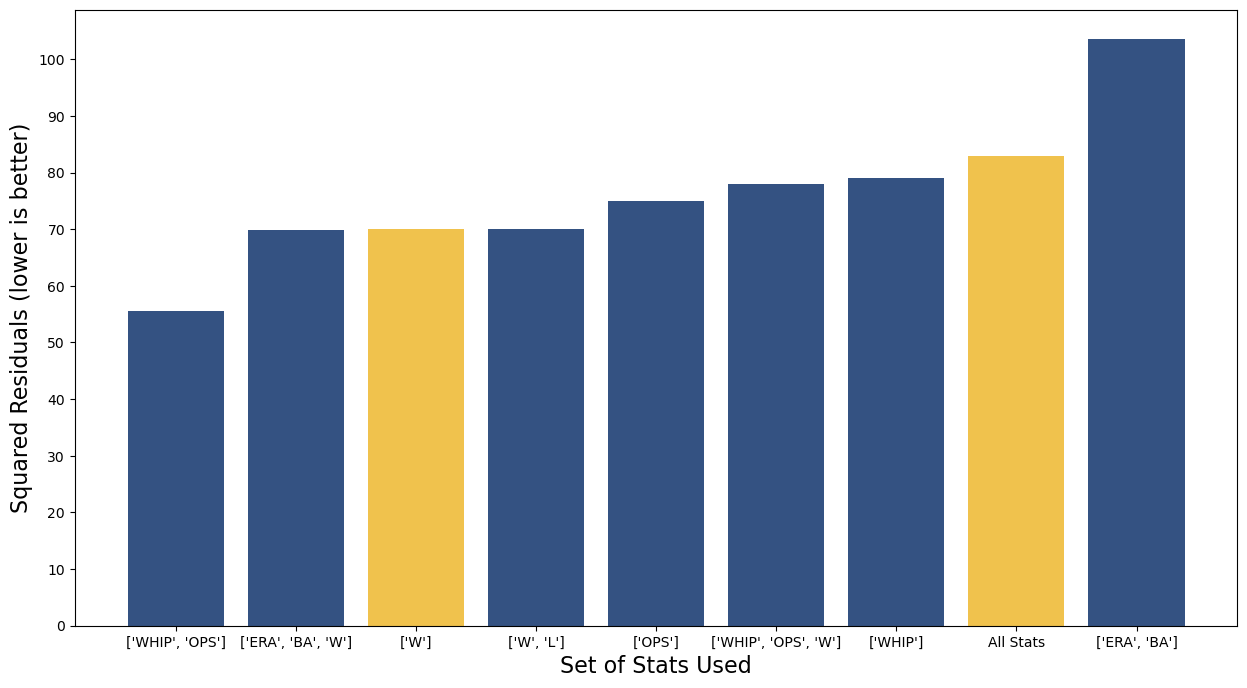

In [129]:
dict_res_sorted = {str(k): v for k, v in sorted(dict_res.items(), key=lambda item: item[1])}
color_key = ['#f0c24d' if k in ('All Stats', str(['W']))else '#345282' for k in dict_res_sorted.keys()]

plt.bar(dict_res_sorted.keys(), dict_res_sorted.values(), color=color_key)
plt.yticks(range(0, int(round(max(list(dict_res_sorted.values())), -1)) + 10, 10))

plt.xlabel('Set of Stats Used', fontsize=16)
plt.ylabel('Squared Residuals (lower is better)', fontsize=16)
plt.gcf().set_size_inches(15, 8)
plt.show()

In [107]:
x_feat_list = list(master_df_ranked_playoffs.columns)[2:-1]
correct_count = 0
success_dict = {}
num_trials = 10
trials = 0
all_preds = pd.DataFrame()


while trials < num_trials:
    random_stats = random.sample(x_feat_list, 3)
    # run 25 decision trees (one for every season since 1999) on 3 randomly chosen stats
    for year in range(1999, 2024):
        playoff_preds, accuracy = train_dec_tree(master_df_ranked, year, random_stats)
        for idx, row in playoff_preds.iterrows():
            if row[1] == 5 & row[2] == 5:
                correct_count += 1
    if correct_count > 0:
        success_dict[str(random_stats)] = round(correct_count / 25, 2)
        correct_count = 0
        trials += 1
    
# run 25 decision trees (one for every season since 1999) on all predictor stats
for year in range(1999, 2024):
    playoff_preds, accuracy = train_dec_tree(master_df_ranked, year, x_feat_list)
    for idx, row in playoff_preds.iterrows():
        if row[1] == 5 & row[2] == 5:
            correct_count += 1
        
acc = correct_count / 25
success_dict['All Stats'] = round(correct_count / 25, 2)

correct_countect_count = 0
# run 25 decision trees (one for every season since 1999) on all predictor stats
for year in range(1999, 2024):
    playoff_preds, accuracy = train_dec_tree(master_df_ranked, year, ['W'])
    for idx, row in playoff_preds.iterrows():
        if row[1] == 5 & row[2] == 5:
            correct_count += 1
        
acc = correct_count / 25
success_dict['Wins'] = round(correct_count / 25, 2)

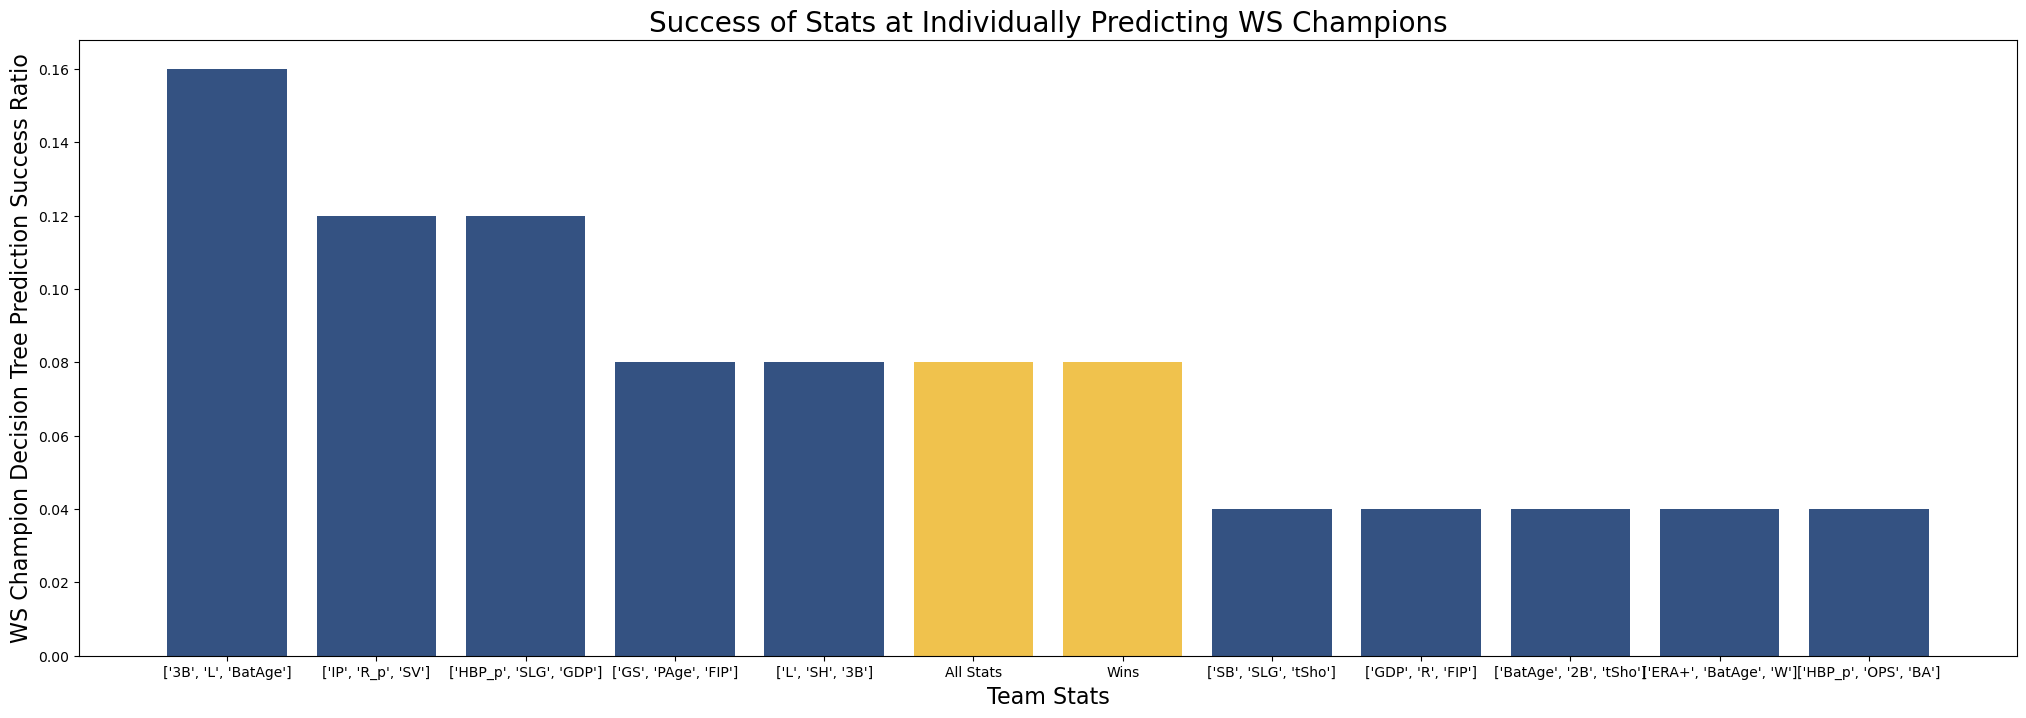

In [108]:
success_dict_sorted = {str(k): v for k, v in sorted(success_dict.items(), key=lambda item: item[1], reverse=True)}
color_key = ['#f0c24d' if k in ('All Stats', 'Wins') else '#345282' for k in success_dict_sorted.keys()]

# plot results from cell above
plt.bar(success_dict_sorted.keys(), success_dict_sorted.values(), color=color_key)
plt.xlabel('Team Stats', fontsize=16)
plt.ylabel('WS Champion Decision Tree Prediction Success Ratio', fontsize=16)
plt.title('Success of Stats at Individually Predicting WS Champions', fontsize=20)
plt.gcf().set_size_inches(25, 8)
plt.show()
plt.show()

## Discussion

The baseline is regular season wins, since regular wins corresponds to seeding for the postseason, and at least hypothetically, the lower seeded teams beat the higher seeded teams.

Using every single team batting and pitching statistic in the decision tree does not yield better results than regular season wins. Of the last 25 World Series champions, our cross validated decision trees predicted only three of them correct on average: that's just 12%. On the other hand, six of the last 25 champions led the league in regular season wins. Fun fact: three of them were the Red Sox.

If this is going to work, we have to be more selected with which stats we use. We ran a random forest regressor to determine feature importance for predicting postseason success, and discovered that some stats, including doubles (2B), stolen bases (SB), and on base plus slugging (OPS) are very relevant. Unfortunately, creating decision trees with just these more relevant stats (and a few others) didn't actually improve our ability to predict postseason winners. Maybe it's time to try something a bit different.

Instead of thinking of our Playoff Success variable as categorical, namely which round of the playoffs did a team make it to, what if we think of it as quantitative? The variable can just as easily represent "number of playoff series a team appeared in". One catch with this line of thinking is that the champions, who are given a score of 5, as opposed to 4, don't actually appear in an extra series. Unless you count the traditional White House visit as a series, but that seems like a stretch. However, since our decision trees don't just predict who wins it all, but also what round teams might get eliminated, we can compare the squared absolute value of the differences between actual playoff success and predicted success for each team. Basically, squared residuals. This gets us a positive integer score, where a score of 0 means that the model got everything correct, and a decision tree that is only using wins (W) will yield a score of 70.

Our base list of stats contained OPS and walks plus hits divided by innings pitched (WHIP), which is a quality measure of how efficient and effective a team's pitchers are. Over 150 iterations, OPS and WHIP produced an average score of just over 55. This may change between runs, because decision tree classifiers are not deterministic. But, that's promising. We might be able to predict overall playoffs success, even if we can't predict exactly who will win the World Series.

There are many combinations of statistics that produce results far worse than the 70 that is our baseline. Take batting average (BA) and earned run averaged (ERA), which are sort of less complicated versions of OPS and WHIP, respectively. They produced a ludicrously high score of almost 104. But interestingly, if you add wins in, the score is only 69, whereas wins combined with OPS and WHIP yields 75.6.

Ultimately, we can't predict who's going to win the World Series. But, we might be able to predict the overall trend of a postseason better than wins can, and we can do it using only two stats: one offensive, one defensive. That's pretty cool.

### Pitfalls and Plans

There's plenty that can go wrong here. We're using some handwaving to treat a categorical variable as a quantitative one, and while it may not be that big of an issue in this particular case, it would be a good idea to come up with a more traditional method of postseason success that's more quantitative, like postseason wins. Another potential flaw is our method of standardizing data across seasons. The league has changed over time, and the spread of statistics have changed with it. We changed each statistic to an integer representing each team's rank in each stat, but there may be better ways to go about it. For example, using standardization to produce something akin to z-scores could allow outliers to remain outliers while still accounting for the evolution of baseball over time.

